In [30]:
%matplotlib inline
from config_calc import *

import matplotlib
import matplotlib.pyplot as plt
from cartopy.util import add_cyclic_point
import matplotlib.gridspec as gridspec
plt.rcParams['mathtext.default']='regular'

from collections import OrderedDict

import cmocean
import colorbrewer
import plot_tools

In [59]:
droot = lambda case: '/glade/p/cesm/bgcwg/cases/%s/ocn/proc/tseries/annual'%case

caselist = OrderedDict([('b40.20th.1deg.bdrd.002',[1995,2005]),
                        ('b40.rcp8_5.1deg.bdrd.002',[2090,2100]),
                        ('b40.rcp8_5.1deg.bdrd.2300.002',[2290,2300])])

varlist = ['PO4','O2','AOU']

files = {v : OrderedDict({}) for v in varlist}

#-- loop over cases
for case,year_range in caselist.items():

    #-- loop over variables
    for v in varlist:
        #-- identify input file
        datestr = '%04d-%04d'%tuple(year_range)
        file_in = sorted(glob(os.path.join(droot(case),'.'.join([case,'pop.h',v,'????-????','nc']))))[0]

        #-- produce time-mean output file
        file_out = os.path.join(diro['work'],'.'.join([case,'pop.h',v,'tavg',datestr,'nc']))
        if not os.path.exists(file_out):
            ds = xr.open_dataset(file_in,decode_times=False,decode_coords=False)
            ds = ds.isel(time=slice(-11,None))
            ds = et.interpret_time(ds,0)
            ds = ds.mean(dim='time',keep_attrs=True)
            ds = ds.expand_dims('time')
            ds.to_netcdf(file_out)

        #-- compute zonal mean        
        file_in = file_out
        file_out = os.path.join(diro['work'],'.'.join([case,'pop.h',v,'tavg_za',datestr,'nc'])) 
        files[v][case] = file_out
        if not os.path.exists(file_out):
            et.pop_calc_zonal_mean(file_in,file_out)


computing zonal mean
computing zonal mean
computing zonal mean
computing zonal mean
computing zonal mean
computing zonal mean
computing zonal mean
computing zonal mean
computing zonal mean


In [63]:
ds = {}
for v in varlist:
    for f in files[v].values():
        print f
        dsi = xr.concat([xr.open_dataset(f,decode_times=False,decode_coords=False) 
                         for f in files[v].values()],dim='time')
        ds = xr.merge((ds,dsi.isel(basins=0)))
ds

/glade/scratch/mclong/calcs/iucn-ch/work/b40.20th.1deg.bdrd.002.pop.h.PO4.tavg_za.1995-2005.nc
/glade/scratch/mclong/calcs/iucn-ch/work/b40.rcp8_5.1deg.bdrd.002.pop.h.PO4.tavg_za.2090-2100.nc
/glade/scratch/mclong/calcs/iucn-ch/work/b40.rcp8_5.1deg.bdrd.2300.002.pop.h.PO4.tavg_za.2290-2300.nc
/glade/scratch/mclong/calcs/iucn-ch/work/b40.20th.1deg.bdrd.002.pop.h.O2.tavg_za.1995-2005.nc
/glade/scratch/mclong/calcs/iucn-ch/work/b40.rcp8_5.1deg.bdrd.002.pop.h.O2.tavg_za.2090-2100.nc
/glade/scratch/mclong/calcs/iucn-ch/work/b40.rcp8_5.1deg.bdrd.2300.002.pop.h.O2.tavg_za.2290-2300.nc
/glade/scratch/mclong/calcs/iucn-ch/work/b40.20th.1deg.bdrd.002.pop.h.AOU.tavg_za.1995-2005.nc
/glade/scratch/mclong/calcs/iucn-ch/work/b40.rcp8_5.1deg.bdrd.002.pop.h.AOU.tavg_za.2090-2100.nc
/glade/scratch/mclong/calcs/iucn-ch/work/b40.rcp8_5.1deg.bdrd.2300.002.pop.h.AOU.tavg_za.2290-2300.nc


<xarray.Dataset>
Dimensions:      (lat_t: 394, lat_t_edges: 395, time: 3, z_t: 60)
Coordinates:
  * lat_t        (lat_t) float32 -79.2205 -78.6863 -78.1521 -77.6179 ...
  * lat_t_edges  (lat_t_edges) float32 -79.4871 -78.9529 -78.4187 -77.8844 ...
  * z_t          (z_t) float32 500.0 1500.0 2500.0 3500.0 4500.0 5500.0 ...
Dimensions without coordinates: time
Data variables:
    PO4          (time, z_t, lat_t) float64 nan nan 1.548 1.539 1.564 1.586 ...
    ANGLET       (time, lat_t) float64 nan nan 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    DXT          (time, lat_t) float64 nan nan 2.568e+06 2.682e+06 2.796e+06 ...
    DYT          (time, lat_t) float64 nan nan 5.94e+06 5.94e+06 5.94e+06 ...
    HT           (time, lat_t) float64 nan nan 6.64e+04 5.451e+04 5.533e+04 ...
    HTE          (time, lat_t) float64 nan nan 5.94e+06 5.94e+06 5.94e+06 ...
    HTN          (time, lat_t) float64 nan nan 2.625e+06 2.739e+06 2.853e+06 ...
    TAREA        (time, lat_t) float64 nan nan 1.525e+13 1.593e+13

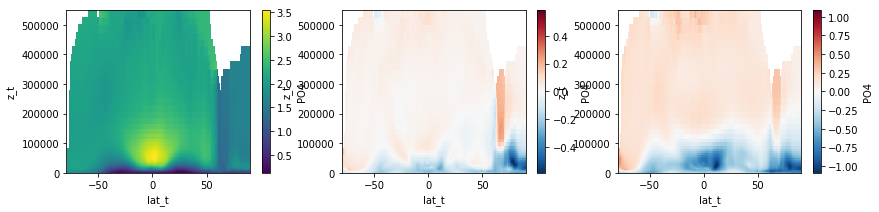

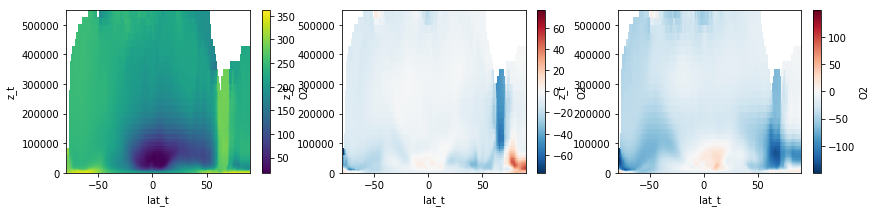

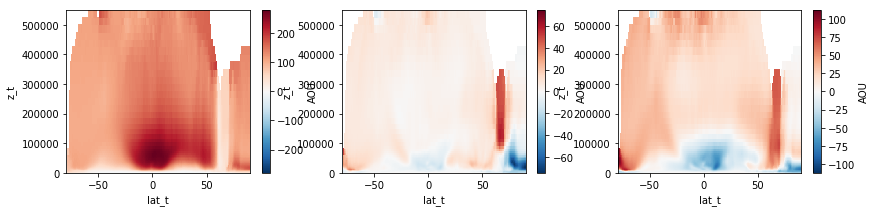

In [71]:
for v in varlist:
    fig = plt.figure(figsize=(14,3))
    ax = fig.add_subplot(1,3,1)
    ds[v][0,:,:].plot()
    ax = fig.add_subplot(1,3,2)
    (ds[v][-2,:,:]-ds[v][0,:,:]).plot()
    ax = fig.add_subplot(1,3,3)
    (ds[v].isel(time=-1)-ds[v].isel(time=0)).plot()

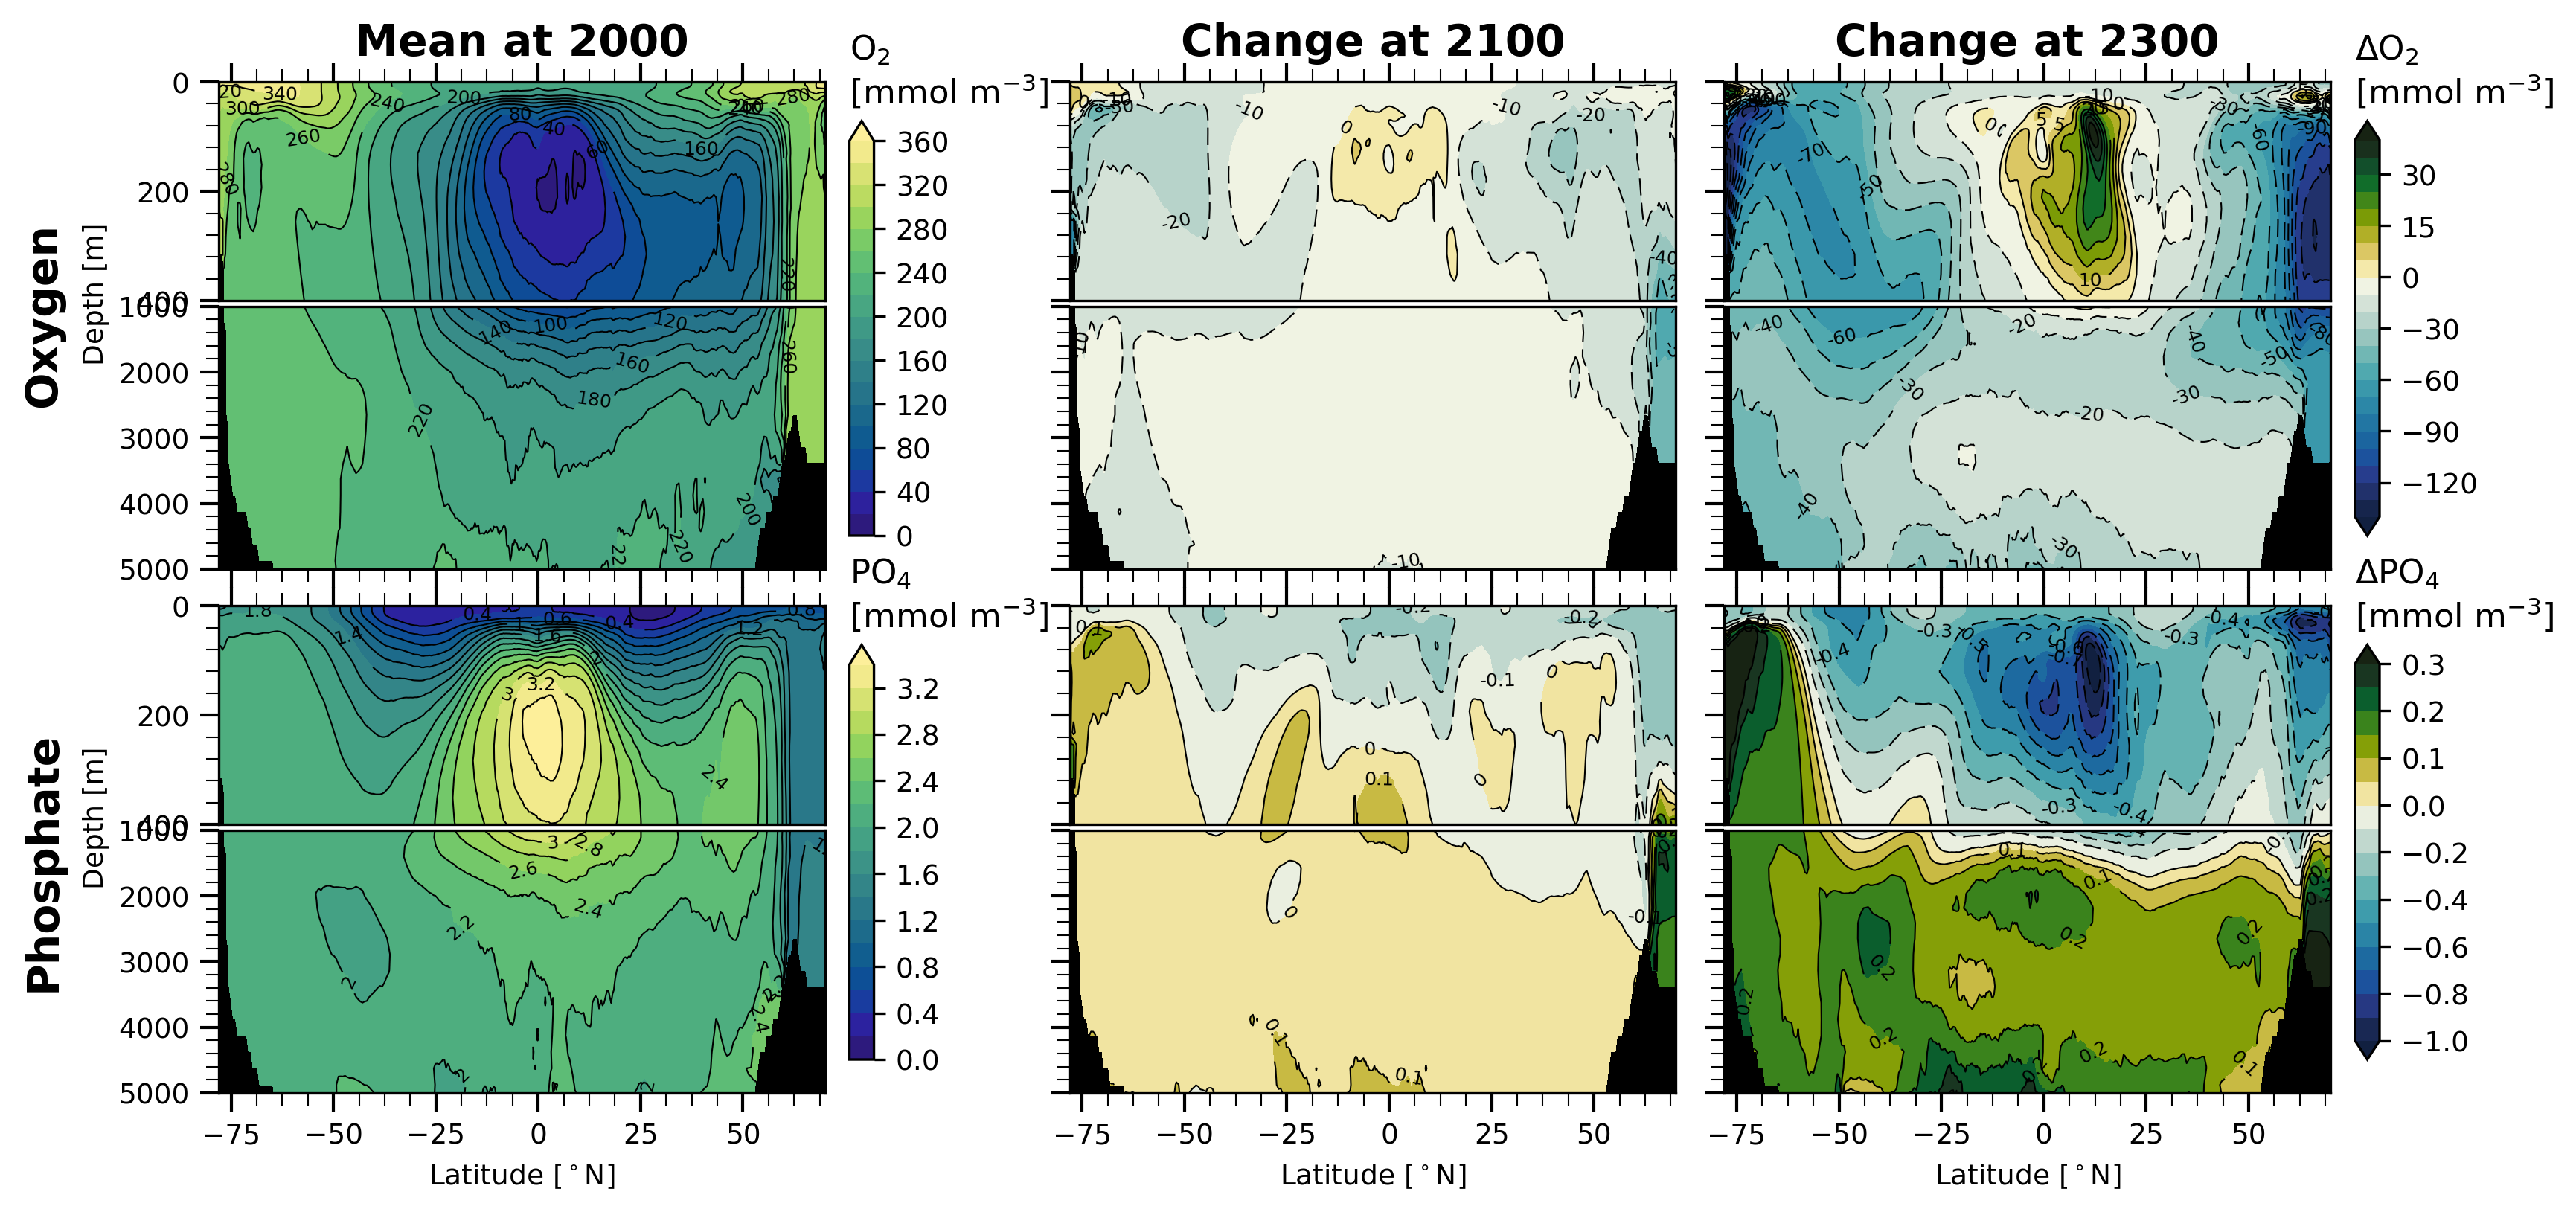

In [132]:
reload(plot_tools)
plot_name = os.path.join(diro['fig'],'global-zonal-mean-2300.pdf')

fig = plt.figure(dpi=300,figsize=(11,6))

gs = gridspec.GridSpec(2,3)

long_name = {'O2':'O$_2$','PO4':'PO$_4$'}

lat = ds['lat_t']
depth = ds['z_t']/100.

obj = {v : [[]]*3 for v in ['O2','AOU','PO4']}

for iv,v in enumerate(['O2','PO4']):
    for ip,p in enumerate(['2000','2100','2300']):
        if ip == 0:
            field = ds[v].isel(time=ip)
            levels = plot_tools.nice_levels(0.,field.max(),30)
            contour_specs = {'levels':levels,'cmap':cmocean.cm.haline,'extend':'max'}
            
        else:
            field = ds[v].isel(time=ip) - ds[v].isel(time=0) 
            if v == 'AOU':
                field = -1.*field

            if v == 'O2':
                levels = np.arange(-140.,40.,10.)
                levels = np.concatenate((np.arange(-140.,0.,10.),np.arange(0.,45,5)))
            elif v == 'PO4':
                levels = np.concatenate((np.arange(-1.,0.,0.1),np.arange(0.,0.35,0.05)))
            else:
                levels = plot_tools.nice_levels(field.min(),field.max(),30)
                
            norm = plot_tools.MidPointNorm(midpoint=0.)
            contour_specs = {'levels':levels,'cmap':cmocean.cm.delta,'norm':norm,'extend':'both'}
                       
        obj[v][ip] = plot_tools.canvas_full_depth_section(lat,depth,field,
                                                          fig = fig,
                                                          gridspec_spec = gs,
                                                          row = iv, col = ip,
                                                          contour_specs = contour_specs,
                                                          xlim = [-78,70])

       
        if ip > 0:
            [ax.set_yticklabels([]) for ax in obj[v][ip]['ax']]
            [ax.set_ylabel('') for ax in obj[v][ip]['ax']]

        if iv < 1:
            [ax.set_xticklabels([]) for ax in obj[v][ip]['ax']]
            [ax.set_xlabel('') for ax in obj[v][ip]['ax']]

        
gs.update(left=0.11, right=0.89, wspace=0.08,hspace=0.075)

#-- shift the right two columns over to make room for colorbar
offset = 0.08
for i in range(2):
    for j in range(1,3):
        p0 = obj['O2'][j]['ax'][i].get_position()
        obj['O2'][j]['ax'][i].set_position([p0.x0+offset,p0.y0,p0.width,p0.height])

        p0 = obj['PO4'][j]['ax'][i].get_position()
        obj['PO4'][j]['ax'][i].set_position([p0.x0+offset,p0.y0,p0.width,p0.height])


#-- add colorbars
for v in ['O2','PO4']:
    for ip in [0,2]:
        p0 = obj[v][ip]['ax'][0].get_position()
        p1 = obj[v][ip]['ax'][1].get_position()

        cbaxes = fig.add_axes([p1.x0+p1.width+0.01,p1.y0+0.025,0.01,p0.height+p1.height-0.05])
        cb = fig.colorbar(obj[v][ip]['cf'][0], cax=cbaxes)
        if ip == 0:
            cbaxes.set_title('%s\n[mmol m$^{-3}]$'%long_name[v],loc='left')
        else:
            cbaxes.set_title('$\Delta$%s\n[mmol m$^{-3}]$'%long_name[v],loc='left')        

fig.text(0.03,0.75,'Oxygen',
         fontsize=14.,
         fontweight = 'semibold',rotation=90)

fig.text(0.03,0.37,'Phosphate',
         fontsize=14.,
         fontweight = 'semibold',rotation=90)

p = obj['O2'][0]['ax'][0].get_position()
fig.text((p.x0+p.x1)/2.,p.y0+p.height+0.02,'Mean at 2000',
         fontsize=14.,
         horizontalalignment = 'center',
         fontweight = 'semibold')

p = obj['O2'][1]['ax'][0].get_position()
fig.text((p.x0+p.x1)/2.,p.y0+p.height+0.02,'Change at 2100',
         fontsize=14.,
         horizontalalignment = 'center',
         fontweight = 'semibold')

p = obj['O2'][2]['ax'][0].get_position()
fig.text((p.x0+p.x1)/2.,p.y0+p.height+0.02,'Change at 2300',
         fontsize=14.,
         horizontalalignment = 'center',
         fontweight = 'semibold')
   
plt.savefig(plot_name,dpi=300,bbox_inches='tight')